# Part 3 Preprocessing and Machine Learning

3. Contents
3.1 Overview
3.2 Preprocessing Data
3.2.1 Text Cleaning
3.2.2 Feature Selection
3.2.3 Feature Scaling
3.2.4 Term-Document Matrices
3.2.5 Transformation Pipeline
3.3 Create a Test Set
3.4 Model Training and Selection
3.4.1 Training and Evaluating Training Data
3.4.2 Cross Validation
3.5 Model Fine-Tuning
3.5.1 Grid Search
3.5.2 Randomized Hyperparameter Search
3.6 Model Analysis
3.6.1 Best Model and Errors
3.6.2 Evaluate System on Test Data
3.7 Discussion

In [468]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from NLP_Pipeline import *

# For text preprocessing
import spacy
from nltk.tokenize import sent_tokenize

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support as score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
import warnings
import plotly.figure_factory as ff
import random
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor

In [469]:
# Read in the data
df = pd.read_pickle('data/df_fromEDA.pkl')

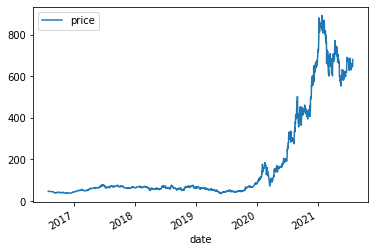

In [470]:
_ = df[df['username'] == 'elonmusk'].plot('date', 'price')

In [471]:
test = df[df['username'] == 'elonmusk'].copy()

In [472]:
test['verification'] = test['price'][0]

In [473]:
pct_change = list(test['percent change'])

In [474]:
del pct_change[0]

In [475]:
pct_change.append(0)

In [476]:
test['target'] = pct_change

In [477]:
test[['percent change', 'target']]

,percent change,target
0,0.017729,-0.010605
1,-0.010605,0.003860
2,0.003860,-0.009819
3,-0.009819,-0.023312
4,-0.023312,-0.000321
...,...,...
2157,0.008789,-0.028068
2158,-0.028068,-0.000031
2159,-0.000031,0.004343
2160,0.004343,0.046107


In [478]:
for i in range(len(test)):
    if i == len(test) - 1:
        quit
    else:
        test['verification'].iloc[i+1] = (test['verification'].iloc[i] * test['percent change'].iloc[i+1]) + test['verification'].iloc[i]
        

In [479]:
test.columns

Index(['date', 'tweet', 'username', 'mentions', 'hashtags', 'video', 'photos',
       'urls', 'replies_count', 'retweets_count', 'likes_count',
       'number of tweets', 'price', 'percent change', 'labels', 'text',
       'n_char', 'n_words', 'avg_word_len', 'sentiment_dict', 'compound_sent',
       'neg_sent', 'neu_sent', 'pos_sent', 'readability', 'verification',
       'target'],
      dtype='object')

In [480]:
features = ['date','mentions', 'hashtags', 'video', 'photos',
       'urls', 'replies_count', 'retweets_count', 'likes_count',
       'number of tweets', 'text', 'price', 'percent change',
       'n_char', 'n_words', 'avg_word_len', 'compound_sent',
       'neg_sent', 'neu_sent', 'pos_sent', 'readability', 'target']

In [481]:
test['cleaned'] = test['text'].apply(lambda x: clean_text(x))

In [482]:
X_vect, _ = vectorize(test['cleaned'], test[features].drop(labels=['text'], axis=1))

In [483]:
y = test[['percent change']]
y

,percent change
0,0.017729
1,-0.010605
2,0.003860
3,-0.009819
4,-0.023312
...,...
2157,0.008789
2158,-0.028068
2159,-0.000031
2160,0.004343


In [484]:
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2)

In [485]:
print(X_train.shape)
print(y_train.shape)

(1729, 8891)
(1729, 1)


In [486]:
print(X_test.shape)
print(y_test.shape)

(433, 8891)
(433, 1)


In [455]:
linreg = LinearRegression(n_jobs=-1, normalize=False)
linreg.fit(X_train.drop(labels=['date', 'percent change', 'price', 'target'], axis=1), y_train)
y_pred = linreg.predict(X_test.drop(labels=['date', 'percent change', 'price', 'target'], axis=1))

In [487]:
%%time
rfreg = RandomForestRegressor(n_jobs=-1)
rfreg.fit(X_train.drop(labels=['date', 'percent change', 'price', 'target'], axis=1), y_train)
y_pred = rfreg.predict(X_test.drop(labels=['date', 'percent change', 'price', 'target'], axis=1))

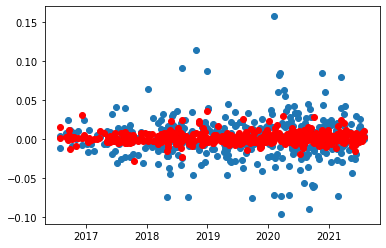

In [495]:
_ = plt.scatter(X_test['date'], y_test)
_ = plt.scatter(X_test['date'], y_pred, color='red')

In [500]:
metrics = pd.DataFrame()

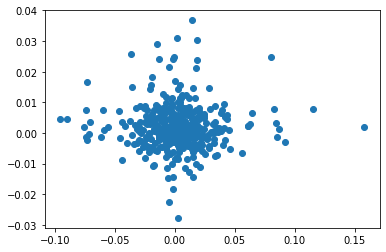

In [497]:
plt.scatter(y_test, y_pred)

In [505]:
X_test['y_pred'] = y_pred

In [506]:
X_test.reset_index(drop=True, inplace=True)

In [507]:
X_sorted = X_test.sort_values(by='date')

In [508]:
X_sorted['verification'] = X_sorted['price']

In [509]:
for i in range(len(X_sorted)):
    if i == len(X_sorted) - 1:
        break
    else:
        X_sorted['verification'].iloc[i+1] = (X_sorted['price'].iloc[i] * X_sorted['target'].iloc[i]) + X_sorted['price'].iloc[i]

In [510]:
X_sorted[['verification', 'price', 'target']]

,verification,price,target
53,46.459999,46.459999,0.003860
228,46.639333,46.639333,-0.009819
150,46.181382,40.466000,0.008766
175,40.820713,41.080002,-0.013567
113,40.522667,41.369999,-0.005573
...,...,...,...
104,664.410019,681.710022,-0.032462
32,659.580017,654.679993,-0.015977
344,644.219971,645.553304,-0.024263
61,629.890015,646.979980,0.004343


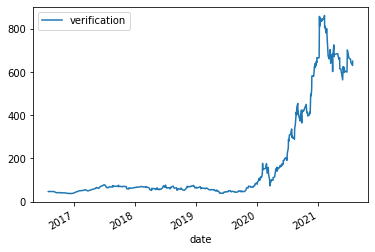

In [511]:
_ = X_sorted.plot('date', 'verification')

In [512]:
X_sorted['pred_price'] = X_sorted['price']
for i in range(len(X_sorted)):
    if i == len(X_sorted) - 1:
        break
    else:
        X_sorted['pred_price'].iloc[i+1] = (X_sorted['price'].iloc[i] * X_sorted['y_pred'].iloc[i]) + X_sorted['price'].iloc[i]

In [513]:
X_sorted['pred_price_2'] = X_sorted['price']
for i in range(len(X_sorted)):
    if i == len(X_sorted) - 1:
        break
    else:
        X_sorted['pred_price_2'].iloc[i+1] = (X_sorted['price'].iloc[i] * X_sorted['pred_price'].iloc[i]) + X_sorted['price'].iloc[i]
        

In [514]:
X_sorted[['pred_price', 'price', 'target', 'y_pred']]

,pred_price,price,target,y_pred
53,46.459999,46.459999,0.003860,0.001630
228,46.535724,46.639333,-0.009819,0.015645
150,47.368999,40.466000,0.008766,0.003111
175,40.591891,41.080002,-0.013567,-0.001210
113,41.030290,41.369999,-0.005573,0.005951
...,...,...,...,...
104,680.137187,681.710022,-0.032462,0.003208
32,683.897120,654.679993,-0.015977,-0.002213
344,653.231199,645.553304,-0.024263,0.007501
61,650.395660,646.979980,0.004343,0.003170


In [586]:
X_sorted['y_pred'] = np.mean(X_sorted['target'])

In [587]:
X_sorted['error'] = np.abs(X_sorted['pred_price'] - X_sorted['price'])

In [588]:
avg_abs_error = np.mean(X_sorted['error'])

In [589]:
avg_abs_error

1.5211835574470105

In [590]:
X_sorted['mean_abs_pct_error'] = 100* (X_sorted['error'] / X_sorted['price'])

In [591]:
X_sorted

,date,mentions,hashtags,video,photos,urls,replies_count,retweets_count,likes_count,number of tweets,...,4030,4031,4032,4033,y_pred,verification,pred_price,pred_price_2,error,mean_abs_pct_error
173,2016-08-04 16:00:00,0.000000,0.000000,0.000000,0.000000,0.693147,3.951244,5.081404,6.142037,1.386294,...,0.0,0.0,0.0,0.0,0.001967,18.129999,18.129999,18.129999,0.000000,0.000000
125,2016-08-10 16:00:00,0.000000,0.000000,0.000000,0.000000,1.098612,4.521789,4.905275,5.840642,1.098612,...,0.0,0.0,0.0,0.0,0.001967,18.190001,18.133652,346.826869,0.906349,4.760235
116,2016-08-17 09:30:00,0.693147,0.000000,0.693147,0.693147,0.000000,4.025352,5.068904,6.617403,0.693147,...,0.0,0.0,0.0,0.0,0.001967,19.170000,18.987697,364.304754,1.442303,7.059731
14,2016-08-19 09:30:00,0.000000,0.693147,0.000000,0.000000,0.693147,2.833213,3.610918,4.330733,1.098612,...,0.0,0.0,0.0,0.0,0.001967,20.170000,20.775125,408.348659,1.815126,9.573452
235,2016-08-19 16:00:00,0.693147,0.000000,0.000000,0.000000,0.693147,3.178054,4.094345,5.652489,0.693147,...,0.0,0.0,0.0,0.0,0.001967,18.980000,19.030014,412.856358,0.050015,0.263512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,2021-05-14 16:00:00,0.693147,0.693147,0.000000,0.000000,0.000000,5.501258,5.342334,7.421178,0.693147,...,0.0,0.0,0.0,0.0,0.001967,53.969976,55.297624,3829.058007,3.567625,6.896626
94,2021-06-10 09:30:00,0.000000,0.693147,0.000000,0.000000,0.693147,7.268920,8.652423,10.497974,1.386294,...,0.0,0.0,0.0,0.0,0.001967,51.150000,51.738861,2912.276070,8.061138,13.480164
72,2021-06-29 16:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,4.043051,3.135494,6.013715,0.693147,...,0.0,0.0,0.0,0.0,0.001967,60.299999,60.720020,3153.783872,8.279980,11.999971
11,2021-07-02 09:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,3.688879,2.890372,7.050989,0.693147,...,0.0,0.0,0.0,0.0,0.001967,69.050170,69.967133,4258.681400,1.257134,1.829623


In [592]:
accuracy = 100 - np.mean(X_sorted['mean_abs_pct_error'])

In [593]:
accuracy

95.36957836392459

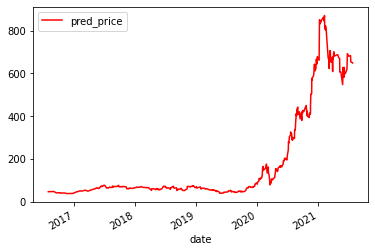

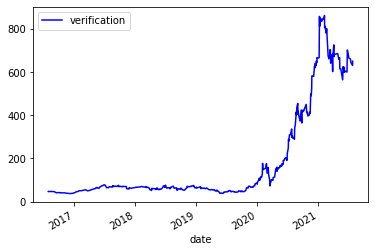

In [515]:
_ = X_sorted.plot('date', 'pred_price', c='r')
_ = X_sorted.plot('date', 'verification', c='b')
plt.show()

In [352]:
X_sorted[['price', 'y_pred']]

,price,y_pred
42,45.234001,-4.065522e+07
150,44.834000,3.223028e+06
368,40.466000,5.850672e+07
160,38.894001,2.304152e+08
158,39.545334,4.361677e+06
...,...,...
101,651.989990,1.160808e+08
390,647.896647,-1.151925e+08
418,650.969971,2.614646e+07
274,644.780029,9.869203e+07


In [528]:
test = df[df['username'] == 'jack'].copy()

In [533]:
test.reset_index(inplace=True, drop=True)

In [534]:
test['verification'] = test['price'][0]

In [535]:
pct_change = list(test['percent change'])

In [536]:
del pct_change[0]

In [537]:
pct_change.append(0)

In [538]:
test['target'] = pct_change

In [539]:
test[['percent change', 'target']]

,percent change,target
0,0.015253,-0.009816
1,-0.009816,0.009913
2,0.009913,0.004629
3,0.004629,-0.002271
4,-0.002271,0.031872
...,...,...
1317,-0.005152,-0.012942
1318,-0.012942,0.037804
1319,0.037804,-0.007064
1320,-0.007064,-0.006575


In [540]:
for i in range(len(test)):
    if i == len(test) - 1:
        quit
    else:
        test['verification'].iloc[i+1] = (test['verification'].iloc[i] * test['percent change'].iloc[i+1]) + test['verification'].iloc[i]
        

In [541]:
test.columns

Index(['date', 'tweet', 'username', 'mentions', 'hashtags', 'video', 'photos',
       'urls', 'replies_count', 'retweets_count', 'likes_count',
       'number of tweets', 'price', 'percent change', 'labels', 'text',
       'n_char', 'n_words', 'avg_word_len', 'sentiment_dict', 'compound_sent',
       'neg_sent', 'neu_sent', 'pos_sent', 'readability', 'verification',
       'target'],
      dtype='object')

In [542]:
features = ['date','mentions', 'hashtags', 'video', 'photos',
       'urls', 'replies_count', 'retweets_count', 'likes_count',
       'number of tweets', 'text', 'price', 'percent change',
       'n_char', 'n_words', 'avg_word_len', 'compound_sent',
       'neg_sent', 'neu_sent', 'pos_sent', 'readability', 'target']

In [543]:
test['cleaned'] = test['text'].apply(lambda x: clean_text(x))

In [544]:
X_vect, _ = vectorize(test['cleaned'], test[features].drop(labels=['text'], axis=1))

In [545]:
y = test[['percent change']]
y

,percent change
0,0.015253
1,-0.009816
2,0.009913
3,0.004629
4,-0.002271
...,...
1317,-0.005152
1318,-0.012942
1319,0.037804
1320,-0.007064


In [546]:
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2)

In [547]:
print(X_train.shape)
print(y_train.shape)

(1057, 4055)
(1057, 1)


In [548]:
print(X_test.shape)
print(y_test.shape)

(265, 4055)
(265, 1)


In [549]:
%%time
rfreg = RandomForestRegressor(n_jobs=-1)
rfreg.fit(X_train.drop(labels=['date', 'percent change', 'price', 'target'], axis=1), y_train)
y_pred = rfreg.predict(X_test.drop(labels=['date', 'percent change', 'price', 'target'], axis=1))

CPU times: user 59.8 s, sys: 219 ms, total: 1min
Wall time: 17.7 s


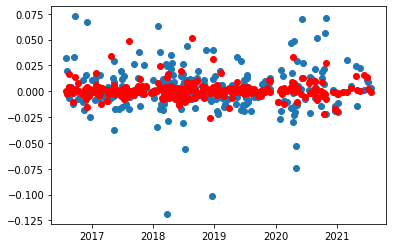

In [550]:
_ = plt.scatter(X_test['date'], y_test)
_ = plt.scatter(X_test['date'], y_pred, color='red')

In [551]:
metrics = pd.DataFrame()

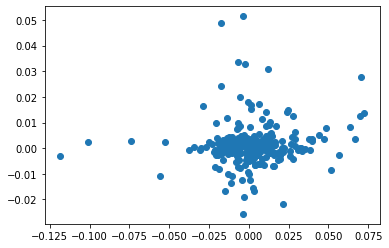

In [552]:
plt.scatter(y_test, y_pred)

In [553]:
X_test['y_pred'] = y_pred

In [554]:
X_test.reset_index(drop=True, inplace=True)

In [555]:
X_sorted = X_test.sort_values(by='date')

In [556]:
X_sorted['verification'] = X_sorted['price']

In [557]:
for i in range(len(X_sorted)):
    if i == len(X_sorted) - 1:
        break
    else:
        X_sorted['verification'].iloc[i+1] = (X_sorted['price'].iloc[i] * X_sorted['target'].iloc[i]) + X_sorted['price'].iloc[i]

In [558]:
X_sorted[['verification', 'price', 'target']]

,verification,price,target
173,18.129999,18.129999,0.003310
125,18.190001,19.040001,0.006828
116,19.170000,20.430000,-0.012726
14,20.170000,18.959999,0.001055
235,18.980000,18.980000,-0.006330
...,...,...,...
210,53.969976,51.730000,-0.011212
94,51.150000,59.799999,0.008361
72,60.299999,69.000000,0.000727
11,69.050170,68.709999,0.003591


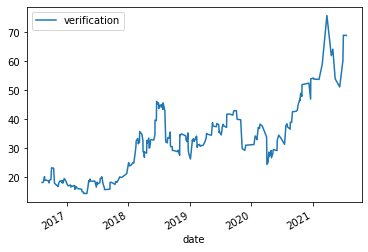

In [559]:
_ = X_sorted.plot('date', 'verification')

In [560]:
X_sorted['pred_price'] = X_sorted['price']
for i in range(len(X_sorted)):
    if i == len(X_sorted) - 1:
        break
    else:
        X_sorted['pred_price'].iloc[i+1] = (X_sorted['price'].iloc[i] * X_sorted['y_pred'].iloc[i]) + X_sorted['price'].iloc[i]

In [561]:
X_sorted['pred_price_2'] = X_sorted['price']
for i in range(len(X_sorted)):
    if i == len(X_sorted) - 1:
        break
    else:
        X_sorted['pred_price_2'].iloc[i+1] = (X_sorted['price'].iloc[i] * X_sorted['pred_price'].iloc[i]) + X_sorted['price'].iloc[i]
        

In [562]:
X_sorted[['pred_price', 'price', 'target', 'y_pred']]

,pred_price,price,target,y_pred
173,18.129999,18.129999,0.003310,0.000201
125,18.133652,19.040001,0.006828,-0.002747
116,18.987697,20.430000,-0.012726,0.016893
14,20.775125,18.959999,0.001055,0.003693
235,19.030014,18.980000,-0.006330,0.003618
...,...,...,...,...
210,55.297624,51.730000,-0.011212,0.000171
94,51.738861,59.799999,0.008361,0.015385
72,60.720020,69.000000,0.000727,0.014016
11,69.967133,68.709999,0.003591,0.001880


In [563]:
X_sorted['error'] = np.abs(X_sorted['pred_price'] - X_sorted['price'])

In [571]:
test = X_sorted.copy()

In [583]:
test['error'] = np.abs(test['y_pred'] - test['target'])
avg_abs_error = np.mean(test['error'])
test['target'] += 0.00001
test['mean_abs_pct_error'] = 100* (test['error'] / test['target'])
accuracy = 100 - np.mean(test['mean_abs_pct_error'])

In [584]:
accuracy

-326.432231738809

In [577]:
test[['error', 'target', 'y_pred']]

,error,target,y_pred
173,0.003108,0.003310,0.000201
125,0.009575,0.006828,-0.002747
116,0.029619,-0.012726,0.016893
14,0.002638,0.001055,0.003693
235,0.009948,-0.006330,0.003618
...,...,...,...
210,0.011383,-0.011212,0.000171
94,0.007024,0.008361,0.015385
72,0.013289,0.000727,0.014016
11,0.001711,0.003591,0.001880


In [573]:
accuracy

-inf

In [564]:
avg_abs_error = np.mean(X_sorted['error'])

In [565]:
avg_abs_error

1.5211835574470105

In [566]:
X_sorted['mean_abs_pct_error'] = 100* (X_sorted['error'] / X_sorted['price'])

In [567]:
X_sorted

,date,mentions,hashtags,video,photos,urls,replies_count,retweets_count,likes_count,number of tweets,...,4030,4031,4032,4033,y_pred,verification,pred_price,pred_price_2,error,mean_abs_pct_error
173,2016-08-04 16:00:00,0.000000,0.000000,0.000000,0.000000,0.693147,3.951244,5.081404,6.142037,1.386294,...,0.0,0.0,0.0,0.0,0.000201,18.129999,18.129999,18.129999,0.000000,0.000000
125,2016-08-10 16:00:00,0.000000,0.000000,0.000000,0.000000,1.098612,4.521789,4.905275,5.840642,1.098612,...,0.0,0.0,0.0,0.0,-0.002747,18.190001,18.133652,346.826869,0.906349,4.760235
116,2016-08-17 09:30:00,0.693147,0.000000,0.693147,0.693147,0.000000,4.025352,5.068904,6.617403,0.693147,...,0.0,0.0,0.0,0.0,0.016893,19.170000,18.987697,364.304754,1.442303,7.059731
14,2016-08-19 09:30:00,0.000000,0.693147,0.000000,0.000000,0.693147,2.833213,3.610918,4.330733,1.098612,...,0.0,0.0,0.0,0.0,0.003693,20.170000,20.775125,408.348659,1.815126,9.573452
235,2016-08-19 16:00:00,0.693147,0.000000,0.000000,0.000000,0.693147,3.178054,4.094345,5.652489,0.693147,...,0.0,0.0,0.0,0.0,0.003618,18.980000,19.030014,412.856358,0.050015,0.263512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,2021-05-14 16:00:00,0.693147,0.693147,0.000000,0.000000,0.000000,5.501258,5.342334,7.421178,0.693147,...,0.0,0.0,0.0,0.0,0.000171,53.969976,55.297624,3829.058007,3.567625,6.896626
94,2021-06-10 09:30:00,0.000000,0.693147,0.000000,0.000000,0.693147,7.268920,8.652423,10.497974,1.386294,...,0.0,0.0,0.0,0.0,0.015385,51.150000,51.738861,2912.276070,8.061138,13.480164
72,2021-06-29 16:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,4.043051,3.135494,6.013715,0.693147,...,0.0,0.0,0.0,0.0,0.014016,60.299999,60.720020,3153.783872,8.279980,11.999971
11,2021-07-02 09:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,3.688879,2.890372,7.050989,0.693147,...,0.0,0.0,0.0,0.0,0.001880,69.050170,69.967133,4258.681400,1.257134,1.829623


In [568]:
accuracy = 100 - np.mean(X_sorted['mean_abs_pct_error'])

In [569]:
accuracy

95.36957836392459

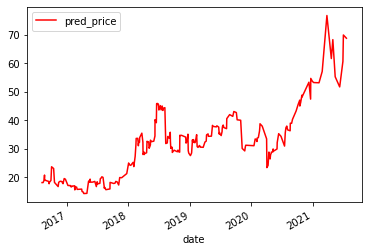

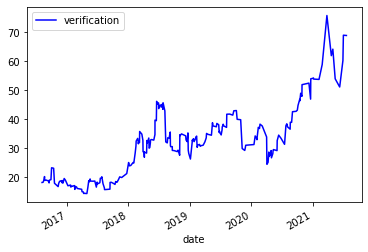

In [570]:
_ = X_sorted.plot('date', 'pred_price', c='r')
_ = X_sorted.plot('date', 'verification', c='b')
plt.show()

In [ ]:
X_test['verification'] = X_test['price'][0]
for i in range(len(X_test)):
    if i == len(X_test) - 1:
        quit
    else:
        X_test['verification'].iloc[i+1] = (X_test['verification'].iloc[i] * y_pred[i]) + X_test['verification'].iloc[i]
        

In [585]:
X_test

,date,mentions,hashtags,video,photos,urls,replies_count,retweets_count,likes_count,number of tweets,...,4025,4026,4027,4028,4029,4030,4031,4032,4033,y_pred
0,2017-05-15 16:00:00,1.098612,0.000000,0.000000,0.000000,1.386294,3.610918,6.035481,7.032624,1.386294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006243
1,2019-07-14 16:00:00,0.693147,0.000000,0.693147,0.693147,0.000000,5.375278,4.158883,6.364751,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001774
2,2018-11-02 09:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,3.178054,0.000000,4.787492,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.006358
3,2017-08-02 09:30:00,0.000000,0.000000,0.000000,0.000000,1.609438,4.718499,4.905275,6.669498,2.708050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005123
4,2019-07-12 16:00:00,0.000000,0.000000,0.000000,0.000000,0.693147,3.713572,4.007333,5.771441,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,2018-06-17 09:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,1.386294,0.000000,2.708050,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.006555
261,2017-02-13 09:30:00,0.693147,0.693147,0.000000,0.000000,1.098612,4.094345,6.950815,7.968320,1.098612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004052
262,2018-09-07 09:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,3.891820,1.098612,4.007333,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.004682
263,2020-04-21 09:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,1.945910,1.098612,4.007333,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001517


# Preprocessing

To get the text ready for machine learning, we will remove punctuation, stopwords, junkwords, and normalize the text by making it lowercase and lemmatizing it.

## Text Cleaning

In [4]:
# Sample Text
sample = df[df['username'] == 'elonmusk']
sample['date'] = pd.to_datetime(sample['date'])
sample.set_index('date', inplace=True)

We have two tweets from Elon Musk that made headlines for how they affected the stock. August 7th, 2018 caused stocks to jump and May 1st, 2020. Let't take a look at these tweets.

In [5]:
pd.options.display.max_colwidth = 1000
sample_increase = sample['2018-08-07']
sample_decrease = sample['2020-05-01']

In [6]:
sample_increase[['text', 'percent change']]

,text,percent change
date,,
2018-08-07 16:00:00,"Investor support is confirmed. Only reason why this is not certain is that it is contingent on a shareholder vote. Def no forced sales. Hope all shareholders remain. Will be way smoother less disruptive as a private company. Ends negative propaganda from shorts. Yes, but liquidity events would be limited to every 6 months or so like SpaceX Shareholders could either to sell at 420 or hold shares go private Absolutely. Am super appreciative of Tesla shareholders. Will ensure their prosperity in any scenario. My hope is all current investors remain with Tesla even if we are private. Would create special purpose fund enabling anyone to stay with Tesla. Already do this with Fidelitys SpaceX investment. Yes I do not have a controlling vote now would not expect any shareholder to have one if we go private. I will not be selling in either scenario. Good morning 420 Am considering taking Tesla private at 420. Funding secured.",0.103915


In [7]:
sample_decrease[['text' ,'percent change']]

,text,percent change
date,,
2020-05-01 09:30:00,You got it! Exactly Well said This needs to stop,-0.034379
2020-05-01 16:00:00,"Baby due on Monday do not need the cash. Devoting myself to Mars and Earth. Possession just weigh you down. My gf is mad at me Just one stipulation on sale I own Gene Wilders old house. It cannot be torn down or lose any its soul. Rage, rage against the dying of the light of consciousness Exactly. How cheaply freedom is sold. over the land of the free and the home of the brave? Oh, say does that starspangled banner yet wave Gave proof through the night that our flag was still there And the rockets red glare, the bombs bursting in air Now give people back their FREEDOM Tesla stock price is too high I am going to I am selling almost all physical possessions. Will own no house. Incentives matter Starship is making good progress What is real any more",-0.071099


Both twitter samples have Tesla in them. The cleaning needs to be able to conserve the context around the text. Let's extract these key phrases and then look at the spacy stopwords to see if we need to remove any of them.

In [8]:
print(nlp.Defaults.stop_words)

{'all', 'onto', 'may', 'front', 'can', 'own', '‘ll', 'every', 'thereafter', 'whether', 'empty', "'m", 'together', 'perhaps', 'why', 'wherein', 'many', 'something', 'be', 'out', 'your', 'two', 'with', 'ourselves', 'hereupon', 'then', 'within', 'now', 'hers', '‘re', 'myself', 'show', 'amongst', 'still', 'go', 'have', 'among', 'and', 'between', 'nowhere', 'he', 'here', 'you', '’m', '‘d', 'whenever', '’re', 'whoever', 'on', 'because', 'indeed', 'never', 'full', 'upon', 'except', 'not', 'cannot', 'third', 'above', "'ll", 'down', 'seem', 'through', 'next', 'several', '’s', 'we', 'too', 'must', 'those', 'as', 'first', 'for', 'thence', 'thru', 'ever', 'various', 'forty', 'if', 'whole', 'around', 'else', 'whose', 'wherever', 'three', 'call', 'hereafter', 'more', 'nine', 'hence', 'yourself', 'latter', 'during', 'whatever', 'somehow', 'beyond', 'throughout', 'give', 'his', 'another', 'until', 'ours', '‘s', 'no', '’ve', 'him', 'itself', 'were', 'should', 'me', 'that', 'most', 'whither', 'n’t', 'so

In [9]:
# Will add or remove to this list as needed
nlp.Defaults.stop_words.remove("too")

In [10]:
STOP_WORDS = nlp.Defaults.stop_words

In [11]:
sample_increase['cleaned'] = sample_increase['text'].apply(lambda x: clean_text(x, stop_words=STOP_WORDS))
sample_decrease['cleaned'] = sample_decrease['text'].apply(lambda x: clean_text(x, stop_words=STOP_WORDS))

In [12]:
sample_increase[['cleaned']]

,cleaned
date,
2018-08-07 16:00:00,investor support confirm reason certain contingent shareholder vote def force sale hope shareholder remain way smoother disruptive private company end negative propaganda short yes liquidity event limit month like spacex shareholder sell hold share private absolutely super appreciative tesla shareholder ensure prosperity scenario hope current investor remain tesla private create special purpose fund enable stay tesla fidelitys spacex investment yes control vote expect shareholder private selling scenario good morning consider take tesla private funding secure


In [13]:
sample_decrease[['cleaned']]

,cleaned
date,
2020-05-01 09:30:00,got exactly say need stop
2020-05-01 16:00:00,baby monday need cash devote mars earth possession weigh gf mad stipulation sale gene wilder old house tear lose soul rage rage die light consciousness exactly cheaply freedom sell land free home brave oh starspangle banner wave give proof night flag rocket red glare bomb burst air people freedom tesla stock price too high going sell physical possession house incentive matter starship make good progress real


We can see from the cleaned text that there are going to be some words that won't be recognized. Let's look at all short words and see if they can be removed.

In [14]:
%%time
# This can take a bit of time due to the lemmatizer
df['cleaned'] = df['text'].apply(lambda x:clean_text(x, stop_words=STOP_WORDS))

CPU times: user 2min 32s, sys: 3.34 s, total: 2min 35s
Wall time: 2min 50s


In [15]:
all_text = " ".join(df['cleaned'])

In [16]:
small_words = [word for word in all_text.split() if len(word) <= 2]

In [17]:
small_words = set(small_words)

In [18]:
small_words;

Let's remove these

In [19]:
sample_decrease['cleaned'] = sample_decrease['cleaned'].apply(lambda x:" ".join([x for x in x.split() if x not in small_words]))

In [20]:
sample_decrease[['cleaned']]

,cleaned
date,
2020-05-01 09:30:00,got exactly say need stop
2020-05-01 16:00:00,baby monday need cash devote mars earth possession weigh mad stipulation sale gene wilder old house tear lose soul rage rage die light consciousness exactly cheaply freedom sell land free home brave starspangle banner wave give proof night flag rocket red glare bomb burst air people freedom tesla stock price too high going sell physical possession house incentive matter starship make good progress real


This looks like it works. Let's apply it over the whole dataframe.

In [21]:
df['cleaned'] = df['cleaned'].apply(lambda x:" ".join([x for x in x.split() if x not in small_words]))

Let's now look at infrequent words to see if we can remove any of them.

In [22]:
all_text = " ".join(df['cleaned'])

In [23]:
len(all_text)

2253777

In [24]:
freq_words = pd.Series(all_text.split()).value_counts()

In [25]:
rare_words = freq_words[freq_words.values == 1]

In [26]:
rare_words

flippersvery     1
revolutionis     1
californiaas     1
northam          1
besidesall       1
                ..
philosophiesa    1
congregate       1
carmax           1
curbside         1
magentai         1
Length: 14224, dtype: int64

A lot of these are misspellings and can be safely removed. 

In [27]:
df['cleaned'] = df['cleaned'].apply(lambda x:" ".join([x for x in x.split() if x not in rare_words]))

In [28]:
all_text = " ".join(df['cleaned'])
len(all_text)

2112719

## Creating Term-Document Matrices
I will be transforming the text into term-document matrices using Tfidf with varous n-grams. 

In [29]:
features = ['mentions', 'hashtags', 'video', 'photos',
       'urls', 'replies_count', 'retweets_count', 'likes_count',
       'number of tweets',
       'n_char', 'n_words', 'avg_word_len', 'cleaned', 'labels']

In [41]:
def classify(X, y):
    #scaler = MinMaxScaler(feature_range=(0,1))
    #X = scaler.fit_transform(X)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #stratify?
    
    nb = MultinomialNB()
    sgd = SGDClassifier(n_jobs=-1)
    lgr = LogisticRegression(random_state=42)
    svm = SVC(random_state=42)
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    clf = {'NB': nb, 'SGD':sgd, 'LGR':lgr, 'SVM':svm, 'RF':rf}
    
    
    for key in clf.keys():
        kfold = KFold(n_splits = 5)
        #clf[key].fit(X_train, y_train)
        #y_pred = clf[key].predict(X_test)
        score = cross_val_score(clf[key], X, y, cv = kfold, scoring='accuracy', n_jobs=-1)
        print(key)
        print("best accuracy: {:.3f}".format(score.max()))
        print("average accuracy: {:.3f}".format(score.mean()))
        print("accuracy std: {:.3f}".format(score.std()))
        #ac = accuracy_score(y_test, y_pred)
        #print(key, " ---> ", ac)
        #precision, recall, f_score, support = score(y_test, y_pred)
        #print('precision: {}'.format(precision))
        #print('recall: {}'.format(recall))
        
# Generate Confusion Matrix
def plot_confusion_matrix(conf_matrix):
    # https://stackoverflow.com/questions/60860121/plotly-how-to-make-an-annotated-confusion-matrix-using-a-heatmap
    z = np.round(conf_matrix*100)

    x = ['drop', 'no change', 'rise']
    y =  ['drop', 'no change', 'rise']

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    # https://plotly.com/python/builtin-colorscales/
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Blues')

    # add title
    fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                      #xaxis = dict(title='x'),
                      #yaxis = dict(title='x')
                     )
    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Percent True Positives Correctly Predicted",
                            xref="paper",
                            yref="paper"))

    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.35,
                            y=0.5,
                            showarrow=False,
                            text="Real value",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))

    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=50, l=200))

    # add colorbar
    fig['data'][0]['showscale'] = True
    fig.show()
    


# Separate Training and Test Sets

In [31]:
train_set, test_set = train_test_split(df, test_size=0.2)

In [32]:
print(train_set.shape)
print(test_set.shape)

(9357, 26)
(2340, 26)


In [33]:
features = [ 'mentions', 'hashtags', 'video', 'photos', 'urls', 'replies_count',
       'retweets_count', 'likes_count', 'number of tweets', 'n_char',
       'n_words', 'avg_word_len']

In [34]:
best_params = {}

In [42]:
def vectorize(X_text, X_features=None, ngram_range=(1,1), min_df=1):
    tfidf = TfidfVectorizer(ngram_range = ngram_range, min_df = min_df)
    matrix = tfidf.fit_transform(X_text)
    matrix_df = pd.DataFrame(matrix.toarray())
    if type(X_features) != 'NoneType':
        matrix_df = pd.concat([X_features, matrix_df], axis=1)
        return matrix_df, tfidf.get_feature_names
    else:
        return matrix_df, tfidf.get_feature_names
    

In [36]:
x = train_set.sample(frac=0.15)
x.reset_index(inplace=True, drop=True)

In [37]:
X, vocab = vectorize(x['cleaned'], x[features])
y = x['labels']

In [38]:
assert len(X) == len(y)

In [39]:
X, vocab = vectorize(x['cleaned'], x[features])
y = x['labels']
print('ngram range: {}'.format(ngram))
classify(X, y)

NameError: name 'ngram' is not defined

The classifiers with the best accuracy were the Naive Bayes, Random Forests, Stochastic Gradient Descent, and Logistic Regression classifiers. Let's look at these models in-depth.

# Tests

Training on high/low only

In [40]:
df_hi_low = df[df['labels'] != 'no change']

In [41]:
features = df_hi_low.columns

In [42]:
features  = features.drop(labels=['date', 'tweet', 'username', 'price', 'text', 'cleaned'])

In [43]:
df_hi_low.reset_index(inplace=True, drop=True)

In [44]:
df_vect, _ =  vectorize(df_hi_low['cleaned'], df_hi_low[features])

In [45]:
train_set_high = df_vect.sort_values('percent change', ascending=False)[:30]
train_set_low = df_vect.sort_values('percent change', ascending=True)[:30]
train_set_high.reset_index(inplace=True, drop=True)
train_set_low.reset_index(inplace=True, drop=True)

In [46]:
train_set_high.columns

Index([        'mentions',         'hashtags',            'video',
                 'photos',             'urls',    'replies_count',
         'retweets_count',      'likes_count', 'number of tweets',
         'percent change',
       ...
                    10211,              10212,              10213,
                    10214,              10215,              10216,
                    10217,              10218,              10219,
                    10220],
      dtype='object', length=10241)

In [47]:
test_set = df_vect
test_set.reset_index(inplace=True, drop=True)

In [48]:
X_train_high = train_set_high.drop(labels=['labels', 'sentiment_dict','percent change'], axis=1)
y_train_high = train_set_high['labels'].values
X_train_low = train_set_low.drop(labels=[ 'labels', 'sentiment_dict', 'percent change'], axis=1)
y_train_low = train_set_low['labels'].values

In [49]:
X_train_high

,mentions,hashtags,video,photos,urls,replies_count,retweets_count,likes_count,number of tweets,n_char,...,10211,10212,10213,10214,10215,10216,10217,10218,10219,10220
0,1.609438,1.791759,1.791759,1.386294,1.791759,7.414573,8.217169,10.214239,1.791759,6.675823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,2.772589,0.693147,3.988984,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.693147,0.000000,0.000000,0.000000,4.143135,4.204693,6.990257,1.098612,5.117994,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,4.644391,4.691348,6.783325,0.693147,4.442651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.693147,0.000000,0.000000,0.000000,0.693147,3.091042,3.218876,4.844187,0.693147,5.147494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.693147,0.693147,0.000000,8.545586,11.183212,13.090297,1.386294,5.509388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.693147,0.693147,0.693147,0.000000,0.693147,3.850148,5.036953,6.682109,0.693147,4.859812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.098612,0.000000,0.693147,0.693147,1.098612,4.812184,5.323010,7.347300,1.098612,5.303305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.098612,0.000000,1.609438,1.386294,0.693147,5.093750,6.865891,8.861917,2.079442,7.206377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.693147,0.000000,1.098612,1.098612,1.098612,3.806662,3.828641,6.066108,1.098612,5.252273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
X_test_set = test_set.drop(labels=['labels', 'sentiment_dict','percent change'], axis=1)
y_test_set = test_set['labels'].values
X_train_high.reset_index(inplace=True, drop=True)
X_train_low.reset_index(inplace=True, drop=True)

In [51]:
X_train_high = X_train_high > 0

In [52]:
nb = MultinomialNB()
nb.fit(X_train_high, y_train_high)
y_pred = nb.predict(X_test_set)

In [53]:
print(classification_report(y_test_set, y_pred))

              precision    recall  f1-score   support

        drop       0.00      0.00      0.00      3862
        rise       0.51      1.00      0.67      3960

    accuracy                           0.51      7822
   macro avg       0.25      0.50      0.34      7822
weighted avg       0.26      0.51      0.34      7822



In [54]:
%%time

x = train_set_high
x.reset_index(inplace=True, drop=True)
X, _ = vectorize(x['cleaned'], x[features], ngram_range=ngram)
y = x['labels']
clf =  GridSearchCV(nb, cv_grid)
clf.fit(X, y)
print('\n')
print("For {}-grams".format(ngram))
sorted(clf.cv_results_.keys())
results = clf.cv_results_['mean_test_score']
print("Best Parameters for Naive_Bayes: {}".format(clf.best_params_))
print('Best Accuracy over {}-folds : {:.3f}'.format(len(results), results.max()))
print('Average Accuracy {:.3f}'.format(results.mean()))

KeyError: 'cleaned'

# Naive Bayes

In [55]:
# Get current Parameters
nb = MultinomialNB()
print('current params:')
print(nb.get_params())

current params:
{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}


We will be looking at the best parameters for the Multinomial NB Classifier as well as looking at different n_grams. Do examine this, we will be looking at a subset of the dataframe. Let's take a look at Elon Musk's tweets for this.

In [56]:
# Fine Tuning for Naive Bayes

# Smoothing Parameter
alpha = np.linspace(0, 1.0, num=11)

cv_grid = {'alpha':alpha}

In [57]:
%%time
best_score = 0
best_ngram = []
# Iteration over ngrams and alpha
ngram_range = [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
for ngram in ngram_range:
    x = train_set.sample(frac=0.15)
    x.reset_index(inplace=True, drop=True)
    X, _ = vectorize(x['cleaned'], x[features], ngram_range=ngram)
    y = x['labels']
    clf =  GridSearchCV(nb, cv_grid)
    clf.fit(X, y)
    print('\n')
    print("For {}-grams".format(ngram))
    sorted(clf.cv_results_.keys())
    results = clf.cv_results_['mean_test_score']
    print("Best Parameters for Naive_Bayes: {}".format(clf.best_params_))
    print('Best Accuracy over {}-folds : {:.3f}'.format(len(results), results.max()))
    print('Average Accuracy {:.3f}'.format(results.mean()))
    if results.mean() > best_score:
        best_score = results.mean()
        best_ngram = ngram

ValueError: Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'

In [58]:
print("best avg score {:.3f} for {}-grams".format(best_score, best_ngram))
best_params['best_ngram'] = best_ngram

best avg score 0.000 for []-grams


In [59]:
# Get best estimator for NB
best_nb = clf.best_estimator_
best_params['best_nb'] = best_nb

In [60]:
%%time
best_min_df = 0
best_score = 0
# Iteration over min_df
min_df_list = [0, 0.001, 0.01, 0.1, 1]
for min_df in min_df_list:
    x = train_set.sample(frac=0.15)
    x.reset_index(inplace=True, drop=True)
    X, _ = vectorize(x['cleaned'], x[features], ngram_range=best_ngram, min_df = min_df)
    y = x['labels']
    scores = cross_val_score(best_nb, X, y, n_jobs=-1)
    print('scores for {}-gram Naive Bayes with min_df of {}:'.format(best_ngram, min_df))
    print('')
    print(scores)
    print('')
    print('     best score: {}'.format(scores.max()))
    print('     mean score: {}'.format(scores.mean()))
    print('     score std: {}'.format(scores.std()))
    print('')
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_min_df = min_df

ValueError: not enough values to unpack (expected 2, got 0)

In [61]:
print("best avg score {:.3f} for {}-grams".format(best_score, best_min_df))
best_params['best_min_df'] = best_min_df

best avg score 0.000 for 0-grams


In [62]:
%%time
best_features = []
best_score = 0
# Transformations
for iter in range(3):
    for i in range(len(features)):
        feature = random.sample(features, i)
        x = train_set.sample(frac=0.15)
        x.reset_index(inplace=True, drop=True)
        X, _ = vectorize(x['cleaned'], x[feature], ngram_range=best_ngram, min_df = best_min_df)
        y = x['labels']
        scores = cross_val_score(best_nb, X, y, n_jobs=-1)
        if scores.mean() > best_score:
            best_features = feature
            best_score = scores.mean()
        print('scores for {}-gram Naive Bayes with min_df of {} and {}:'.format(best_ngrams, best_min_df, feature))
        print('')
        print(scores)
        print('')
        print('     best score: {}'.format(scores.max()))
        print('     mean score: {}'.format(scores.mean()))
        print('     score std: {}'.format(scores.std()))
        print('')


TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [63]:
print("best score {}".format(best_score))
print('best features {}'.format(best_features))
best_params['best_features'] = best_features
model_params = {}
model_params['best_nb'] = best_params

best score 0
best features []


In [64]:
# Final NB Model Fitting
model_params

{'best_nb': {'best_ngram': [],
  'best_nb': MultinomialNB(alpha=0.0),
  'best_min_df': 0,
  'best_features': []}}

In [65]:
df.reset_index(inplace=True, drop=True)
X, _ = vectorize(df['cleaned'], df[best_features], ngram_range = best_ngram, min_df = best_min_df)
X.reset_index(inplace=True, drop=True)
y = df['labels']

ValueError: not enough values to unpack (expected 2, got 0)

In [66]:
y.reset_index(inplace=True, drop=True)

In [67]:
assert len(X) == len(y)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)
best_nb.fit(X_train, y_train)
y_pred = best_nb.predict(X_test)

ValueError: Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'

In [ ]:
# Classification report
print("Classification report")
print(classification_report(y_test, y_pred))

In [69]:
conf_matrix = confusion_matrix(y_test, y_pred, normalize='pred')

ValueError: Found input variables with inconsistent numbers of samples: [281, 7822]

In [ ]:
plot_confusion_matrix(conf_matrix)

In [ ]:
_ = plot_roc_curve(best_nb, X_test, y_test)

In [ ]:
_ = plot_precision_recall_curve(best_nb, X_test, y_test)

# Stochastic Gradient Descent

In [ ]:
# Get current Parameters
sgd = SGDClassifier()
print('current params:')
print(sgd.get_params())

In [ ]:
# Define the Grid using RandomSearchCV

# loss function
loss = ['hinge', 'log', 'modified_huber',
    'squared_hinge', 'perceptron']

# penalty 
penalty = ['l2', 'l1', 'elasticnet']

# alpha used for calculating optimal learning rate
alpha = np.linspace(0.0001, 0.1, 11)

average = [True, False]


max_iter = np.linspace(1000, 2000, 11)



# Create the random grid
random_grid = {'loss': loss,
               'penalty': penalty,
               'alpha': alpha,
               'average': average,
               'max_iter': max_iter}


In [ ]:
x = train_set.sample(frac=0.15)
x.reset_index(inplace=True, drop=True)
X, _ = vectorize(x['cleaned'], x[features])
y = x['labels']
assert len(X) == len(y)

In [ ]:
#First create the base model to tune
sgd = SGDClassifier()

# Definition of the random search
random_search = RandomizedSearchCV(estimator=sgd,
                                   param_distributions=random_grid,
                                   n_iter=30,
                                   scoring='accuracy',
                                   cv=3,
                                   n_jobs=-1,
                                   verbose=1, 
                                   random_state=42)

# Fit the random search model
random_search.fit(X, y)

In [ ]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

In [ ]:
%%time
#Create the parameter grid based on the results of random search 
max_iter = [1500, 2000, 2500]
alpha = np.linspace(0.0001, 0.1, 11)


param_grid = {
    'max_iter': max_iter,
    'alpha': alpha,
    'penalty': ['l2'],
    'loss':['hinge'],
    'average':[False]
}

# Create a base model
sgd = SGDClassifier(random_state=42)


# Instantiate the grid search model
grid_search = GridSearchCV(estimator=sgd, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X, y)

In [ ]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

In [ ]:
best_sgd = grid_search.best_estimator_

In [ ]:
%%time
best_score = 0
best_ngrams = []
# Cross Validation for various n-gram ranges
for n_gram in ngram_range:
    x = train_set.sample(frac=0.15)
    x.reset_index(inplace=True, drop=True)
    X, _ = vectorize(x['cleaned'], x[features], ngram_range=n_gram)
    y = x['labels']
    scores = cross_val_score(best_sgd, X, y, n_jobs=-1)
    print('scores for {}-gram SGD:'.format(n_gram))
    print('')
    print(scores)
    print('')
    print('     best score: {}'.format(scores.max()))
    print('     mean score: {}'.format(scores.mean()))
    print('     score std: {}'.format(scores.std()))
    print('')
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_ngrams = n_gram

In [ ]:
print('Best score {} with {}-grams'.format(best_score, best_ngrams))

In [ ]:
%%time
best_min_df = 0
best_score = 0
# Iteration over min_df
min_df_list = [0, 0.001, 1]
for min_df in min_df_list:
    x = train_set.sample(frac=0.15)
    x.reset_index(inplace=True, drop=True)
    X, _ = vectorize(x['cleaned'], x[features], ngram_range=best_ngram, min_df = min_df)
    y = x['labels']
    scores = cross_val_score(best_sgd, X, y, n_jobs=-1)
    print('scores for {}-gram SGD with min_df of {}:'.format(best_ngram, min_df))
    print('')
    print(scores)
    print('')
    print('     best score: {}'.format(scores.max()))
    print('     mean score: {}'.format(scores.mean()))
    print('     score std: {}'.format(scores.std()))
    print('')
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_min_df = min_df

In [ ]:
print('Best score {} with a min_df of {}'.format(best_score, best_min_df))

In [ ]:
%%time
best_features = []
best_score = 0
for iter in range(3):
    for i in range(len(features)):
        feature = random.sample(features, i)
        x = train_set.sample(frac=0.15)
        x.reset_index(inplace=True, drop=True)
        X, _ = vectorize(x['cleaned'], x[feature], ngram_range=best_ngram, min_df = best_min_df)
        y = x['labels']
        scores = cross_val_score(best_sgd, X, y, n_jobs=-1)
        if scores.mean() > best_score:
            best_features = feature
            best_score = scores.mean()
        print('scores for {}-gram SGD with min_df of {} and {}:'.format(best_ngrams, best_min_df, feature))
        print('')
        print(scores)
        print('')
        print('     best score: {}'.format(scores.max()))
        print('     mean score: {}'.format(scores.mean()))
        print('     score std: {}'.format(scores.std()))
        print('')


In [ ]:
print('Best score of {} with the following features: {}'.format(best_score, best_features))

   # Final Model Fitting

In [ ]:
print('model: {}'.format(best_sgd))
print('ngrams: {}'.format(best_ngrams))
print('min_df: {}'.format(best_min_df))
print('best features: {}'.format(best_features))

In [ ]:
data.reset_index(inplace=True, drop=True)
X, _ = vectorize(data['cleaned'], data[best_features], ngram_range = best_ngrams, min_df = best_min_df)
y = data['labels']

In [ ]:
assert len(X) == len(y)

In [ ]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)
best_sgd.fit(X_train, y_train)
y_pred = best_sgd.predict(X_test)

In [ ]:
# Classification report
print("Classification report")
print(classification_report(y_test, y_pred))

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred, normalize='pred')

In [ ]:
plot_confusion_matrix(conf_matrix)

In [ ]:
_ = plot_roc_curve(best_sgd, X_test, y_test)

In [ ]:
_ = plot_precision_recall_curve(best_sgd, X_test, y_test)

# Logistic Regression

In [ ]:
lgr = LogisticRegression()
print(lgr.get_params())

In [ ]:
# Define the Grid using RandomSearchCV

penalty = ['l1', 'l2', 'elasticnet', 'none']

max_iter = [50, 100, 150]


C = [0.0001, 0.001, 0.01, 1.0]

intercept_scaling = [1.0, 2.0, 3.0]

solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']


# Create the random grid
random_grid = {
               'penalty': penalty,
                'max_iter': max_iter,
               'C': C,
               'intercept_scaling': intercept_scaling,
                'solver':solver}


In [ ]:
x = train_set.sample(frac=0.15)
x.reset_index(inplace=True, drop=True)
X, _ = vectorize(x['cleaned'], x[features])
y = x['labels']
assert len(X) == len(y)

In [ ]:
#First create the base model to tune
lgr = LogisticRegression(random_state=42)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lgr,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3,
                                   n_jobs=-1,
                                   verbose=1, 
                                   random_state=42)

# Fit the random search model
random_search.fit(X, y)

In [ ]:
random_search.best_params_

In [ ]:
best_lgr = random_search.best_estimator_

In [ ]:
random_search.best_score_

In [ ]:
%%time
best_score = 0
best_ngrams = []
# Cross Validation for various n-gram ranges
for n_gram in ngram_range:
    x = train_set.sample(frac=0.15)
    x.reset_index(inplace=True, drop=True)
    X, _ = vectorize(x['cleaned'], x[features], ngram_range=n_gram)
    y = x['labels']
    scores = cross_val_score(best_lgr, X, y, n_jobs=-1)
    print('scores for {}-gram LGR:'.format(n_gram))
    print('')
    print(scores)
    print('')
    print('     best score: {}'.format(scores.max()))
    print('     mean score: {}'.format(scores.mean()))
    print('     score std: {}'.format(scores.std()))
    print('')
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_ngrams = n_gram

In [ ]:
print('Best score {} with {}-grams'.format(best_score, best_ngrams))

In [ ]:
%%time
best_features = []
best_score = 0
for iter in range(3):
    for i in range(len(features)):
        feature = random.sample(features, i)
        x = train_set.sample(frac=0.15)
        x.reset_index(inplace=True, drop=True)
        X, _ = vectorize(x['cleaned'], x[feature], ngram_range=best_ngrams)
        y = x['labels']
        scores = cross_val_score(best_lgr, X, y, n_jobs=-1)
        if scores.mean() > best_score:
            best_features = feature
            best_score = scores.mean()
        print('scores for {}-gram LGR with  {}:'.format(best_ngrams, feature))
        print('')
        print(scores)
        print('')
        print('     best score: {}'.format(scores.max()))
        print('     mean score: {}'.format(scores.mean()))
        print('     score std: {}'.format(scores.std()))
        print('')


In [ ]:
print('Best score of {} with the following features: {}'.format(best_score, best_features))

# Final Model Fitting

In [ ]:
print('model: {}'.format(best_lgr))
print('ngrams: {}'.format(best_ngrams))
print('best features: {}'.format(best_features))

In [ ]:
data.reset_index(inplace=True, drop=True)
X, _ = vectorize(data['cleaned'], data[best_features], ngram_range = best_ngrams)
y = data['labels']

In [ ]:
assert len(X) == len(y)

In [ ]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)
best_lgr.fit(X_train, y_train)
y_pred = best_lgr.predict(X_test)

In [ ]:
# Classification report
print("Classification report")
print(classification_report(y_test, y_pred))

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred, normalize='pred')

In [ ]:
plot_confusion_matrix(conf_matrix)

In [ ]:
_ = plot_roc_curve(best_lgr, X_test, y_test)

In [ ]:
_ = plot_precision_recall_curve(best_lgr, X_test, y_test)

# Other Classification Methods

## Training models on a labelled corpus

In [71]:
ls

Capstone 1 Final Report.ipynb
Capstone_1_Report.ipynb
DataWrangling-Copy1.ipynb
DataWrangling.ipynb
NLP_Pipeline.py
Preprocessing and Machine Learning-Copy1.ipynb
Preprocessing and Machine Learning-Copy2.ipynb
Preprocessing and Machine Learning.ipynb
__pycache__/
archive.zip
corpus_fromDW.pkl
data/
plots/


In [103]:
file = 'data/archive/all-data.csv'
import chardet
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result
# Using a labelled corpus
corpus = pd.read_csv('data/archive/all-data.csv', encoding='Windows-1252', header=None, names=['sentiment', 'cleaned'])

In [352]:
corpus = pd.read_csv('data/archive/FinancialPhraseBank/Sentences_AllAgree.txt', delimiter='\@' ,encoding='Windows-1252', header=None, names=[ 'cleaned', 'sentiment'])

In [353]:
corpus

,cleaned,sentiment
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",neutral
1,"For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",positive
2,"In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .",positive
3,Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .,positive
4,"Operating profit totalled EUR 21.1 mn , up from EUR 18.6 mn in 2007 , representing 9.7 % of net sales .",positive
...,...,...
2259,"Operating result for the 12-month period decreased from the profit of EUR0 .4 m while turnover decreased from EUR5 .6 m , as compared to 2004 .",negative
2260,"HELSINKI Thomson Financial - Shares in Cargotec fell sharply in early afternoon trade after the cargo handling group posted a surprise drop in April-June profits , which overshadowed the large number of new orders received during the three months .",negative
2261,LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .,negative
2262,"Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn .",negative


In [359]:
%%time
bin_range = [[-.3, -.1, .1, .3], [-.3, -.05, .05, .3],
             [-.3, -.01, .01, .3], [-.3, -.005, .005, .3], [-.3, -.001, .001, .3]]
for brange in bin_range:
    test = df[['tweet', 'percent change']].copy()
    test['cleaned'] = test['tweet'].apply(lambda x: clean_text(x, preserve_syntax=True))
    test['sentiment'] = pd.cut(test['percent change'], bins=brange, labels=['negative', 'neutral', 'positive'] )
    print(test['sentiment'].value_counts())
    corpus['train/test'] = 'train'
    test['train/test'] = 'test'
    test.drop(labels = ['percent change', 'tweet'], axis=1, inplace=True)
    corpus = corpus[corpus['sentiment'] != 'neutral']
    test = test[test['sentiment'] != 'neutral']
    test = test.sample(50, replace=False)
    new_df = pd.concat([test, corpus])
    new_df.reset_index(inplace=True, drop=True)
    to_merge = new_df.drop('cleaned', axis=1)
    new_df_vect, _ = vectorize(new_df['cleaned'], ngram_range=(1,2))
    new_df_full = pd.concat([to_merge, new_df_vect], axis=1)
    X_train, X_test, y_train, y_test = new_df_full[new_df_full['train/test'] == 'train'].drop(labels=['sentiment','train/test'], axis=1),new_df_full[new_df_full['train/test'] == 'test'].drop(labels=['sentiment', 'train/test'], axis=1), new_df_full[new_df_full['train/test'] == 'train']['sentiment'],new_df_full[new_df_full['train/test'] == 'test']['sentiment']
    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    print(brange)
    print()
    print(accuracy_score(y_pred, y_test))

neutral     11636
positive       39
negative       22
Name: sentiment, dtype: int64
[-0.3, -0.1, 0.1, 0.3]

0.7
neutral     11330
positive      201
negative      166
Name: sentiment, dtype: int64
[-0.3, -0.05, 0.05, 0.3]

0.46
neutral     7712
positive    2102
negative    1883
Name: sentiment, dtype: int64
[-0.3, -0.01, 0.01, 0.3]

0.42
neutral     5229
positive    3417
negative    3051
Name: sentiment, dtype: int64
[-0.3, -0.005, 0.005, 0.3]

0.56
positive    5418
negative    4821
neutral     1458
Name: sentiment, dtype: int64
[-0.3, -0.001, 0.001, 0.3]

0.5
CPU times: user 40.9 s, sys: 1.25 s, total: 42.2 s
Wall time: 42.7 s


neutral     5229
positive    3417
negative    3051
Name: sentiment, dtype: int64

In [289]:
test.columns

Index(['tweet', 'percent change', 'cleaned', 'sentiment', 'train/test'], dtype='object')

In [338]:
to_merge

,sentiment,train/test
0,positive,test
1,negative,test
2,negative,test
3,negative,test
4,positive,test
...,...,...
1402,negative,train
1403,negative,train
1404,negative,train
1405,negative,train


In [340]:
new_df_vect

,0,1,2,3,4,5,6,7,8,9,...,17134,17135,17136,17137,17138,17139,17140,17141,17142,17143
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [343]:
y_train

100     positive
101     positive
102     positive
103     positive
104     positive
          ...   
1402    negative
1403    negative
1404    negative
1405    negative
1406    negative
Name: sentiment, Length: 1307, dtype: object

In [344]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
accuracy_score(y_pred, y_test)

0.51

In [312]:
corpus['labels'] = corpus['labels'].map({'Bearish':'drop', 'Bullish':'rise'})
corpus['text'] = corpus['tweet'].apply(lambda x: clean_text(x, preserve_syntax=True))

KeyError: 'labels'

In [ ]:
all_text = " ".join(corpus['text'][:1000])

In [ ]:
doc = nlp(all_text)

In [ ]:
ents = {}
counts = 0
for ent in doc.ents:
    if ent.label_ in ents.keys():
        ents[ent.label_] += 1
    else:
        ents[ent.label_] = 1

In [ ]:
ents_df = pd.DataFrame.from_dict(ents, orient='index')

In [ ]:
ents_df.sort_values(by=0, ascending=False)

In [ ]:
corpus['username'] = 'stock_twits'

In [ ]:
corpus.head()

In [ ]:
corpus['cleaned'] = corpus['text'].apply(lambda x: clean_text(x))

In [ ]:
corpus_test = df.copy()

In [ ]:
corpus_test['labels'] = 'rise'
corpus_test['labels'][corpus_test['percent change'] <=0] = 'drop'

In [ ]:
corpus_test['labels'].value_counts()

In [ ]:
corpus['labels'].value_counts()

In [ ]:
corpus_train = corpus[corpus['labels'] == 'drop']
corpus_rise = corpus[corpus['labels'] == 'rise']
corpus_train = pd.concat([corpus_train, corpus_rise.sample(frac=0.25)])
corpus_train['labels'].value_counts()

In [ ]:
len(corpus_test[corpus_test['username'] == 'elonmusk'])

In [ ]:
### KEEP HASHTAGS!!!
full_corpus.reset_index(inplace=True, drop=True)

In [ ]:
usernames = list(df['username'].unique())

In [ ]:
%%time
for user in usernames:
    print(user.upper())
    for ngram in ngram_range: 
        corpus_test_user = corpus_test[corpus_test['username'] == user]
        corpus_test_user = corpus_test_user.sample(frac=0.5)
        corpus_train.reset_index(inplace=True, drop=True)
        corpus_test_user.reset_index(inplace=True, drop=True)
        full_corpus = pd.concat([corpus_train, corpus_test_user[['labels', 'tweet', 'text', 'cleaned', 'username']]])
        full_corpus.reset_index(inplace=True, drop=True)
        X, _ = vectorize(full_corpus['cleaned'], full_corpus[['labels', 'username']], ngram_range=ngram)
        X_train = X[X['username'] == 'stock_twits'].drop(labels=['username'], axis=1)
        X_test = X[X['username'] == user].drop(labels=['username'], axis=1)
        X_train = X_train.sample(frac=0.1)
        X_test = X_test.sample(frac=0.1)
        y_train = X_train['labels']
        y_test = X_test['labels']
        X_train.drop('labels', inplace=True, axis=1)
        X_test.drop('labels', inplace=True, axis=1)
        
        nb = MultinomialNB()
        nb.fit(X_train, y_train)
        y_pred = nb.predict(X_test)
        
        print('ngram_range {}'.format(ngram))
        print(classification_report(y_test, y_pred))
        print("")

In [ ]:
user = 'elonmusk'
corpus_test_user = corpus_test[corpus_test['username'] == user]
corpus_test_user = corpus_test_user.sample(frac=0.5)
corpus_train.reset_index(inplace=True, drop=True)
corpus_test_user.reset_index(inplace=True, drop=True)
full_corpus = pd.concat([corpus_train, corpus_test_user[['labels', 'tweet', 'text', 'cleaned', 'username']]])
full_corpus.reset_index(inplace=True, drop=True)
X, _ = vectorize(full_corpus['cleaned'], full_corpus[['labels', 'username']], ngram_range=(2,2))
X_train = X[X['username'] == 'stock_twits'].drop(labels=['username'], axis=1)
X_test = X[X['username'] == user].drop(labels=['username'], axis=1)
X_train = X_train.sample(frac=0.1)
X_test = X_test.sample(frac=0.1)
y_train = X_train['labels']
y_test = X_test['labels']
X_train.drop('labels', inplace=True, axis=1)
X_test.drop('labels', inplace=True, axis=1)

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print(classification_report(y_test, y_pred))
print("")
_ = plot_precision_recall_curve(nb, X_test, y_test)
_ = plot_roc_curve(nb, X_test, y_test)

In [ ]:
X_train = X[X['username'] == 'stock_twits'].drop(labels=['labels'])
y_train = X['labels'][X['username'] == 'stock_twits']

In [ ]:
x = df[df['username'] == 'elonmusk']
x.reset_index(inplace=True, drop=True)
X, _ = vectorize(x['cleaned'], x[features], ngram_range=(3,3))
X.reset_index(inplace=True, drop=True)
y = x['labels'].reset_index(drop=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
sgd.fit(X_train, y_train)


In [ ]:
y_pred = sgd.predict(X_test)

In [ ]:
#Classification report
print("Classification report")
print(classification_report(y_test, y_pred))

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred, normalize='pred')

In [ ]:
conf_matrix

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,1))
model = tfidf.fit_transform(df['cleaned'])
X = pd.concat([df[features], pd.DataFrame(model.toarray())], axis=1)
X.reset_index(inplace=True, drop=True)
y = df['labels'].reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [ ]:
sgd

In [ ]:
test_2 = vectorize(df['cleaned'])

In [ ]:
test_2

## Baseline Machine Learning

In [ ]:
# Elon musk
df_elon = df[df['username']=='elonmusk']
df_elon.reset_index(inplace=True, drop=True)

In [ ]:
df_elon_features = pd.DataFrame(scaler.fit_transform(df_elon[features]), columns=features)

In [ ]:
# Cleaned with features
tfidf = TfidfVectorizer()
elon_matrix = tfidf.fit_transform(df_elon['cleaned'])
X = pd.concat([df_elon_features, pd.DataFrame(elon_matrix.toarray())], axis=1)

In [ ]:
y = df_elon['labels']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
classify(X_train, y_train)

In [ ]:
# Cleaned phrases with features
elon_phrases = just_phrases[just_phrases['username'] == 'elonmusk']
elon_phrases.reset_index(inplace=True, drop=True)
elon_phrases_feat = pd.DataFrame(scaler.fit_transform(elon_phrases[features]), columns=features)
tfidf = TfidfVectorizer()
elon_matrix = tfidf.fit_transform(elon_phrases['cleaned'])
X = pd.concat([elon_phrases_feat, pd.DataFrame(elon_matrix.toarray())], axis=1)
y = elon_phrases['labels']
classify(X, y)

In [ ]:
# Using a labelled corpus
stock_twits = pd.read_csv('data/stocktwits_labelled.csv', header=None, names=['labels', 'text'])

In [ ]:
%%time
stock_twits['cleaned'] = stock_twits['text'].apply(lambda x: clean_text(x))

In [ ]:
stock_twits['username'] = 'stock_twits'
stock_twits['target'] = stock_twits['labels']

In [ ]:
bins = [[-.3, -.1, .1, .3], [-.3, -0.05, 0.05, .3], [-.3, -0.01, 0.01, .3], [-.3, -0.005, 0.005, .3]]
labels = ['drop', 'no change', 'rise']
for bn in bins:
    elon_phrases = just_phrases[just_phrases['username'] == 'elonmusk']
    elon_phrases['labels'] = pd.cut(elon_phrases['percent change'], bn, labels=labels)
    elon_phrases.reset_index(inplace=True, drop=True)
    elon_phrases_feat = pd.DataFrame(scaler.fit_transform(elon_phrases[features]), columns=features)
    elon_phrases = elon_phrases[elon_phrases['labels'] != 'no change']
    elon_phrases['target'] = 'Bearish'
    elon_phrases['target'][elon_phrases['labels'] == 'rise'] = 'Bullish'
    df_new = pd.concat([stock_twits[['cleaned', 'username', 'target']], elon_phrases[['cleaned', 'username', 'target']]])
    df_new.reset_index(inplace=True, drop=True)
    tfidf = TfidfVectorizer()
    matrix = tfidf.fit_transform(df_new['cleaned'])
    X = pd.concat([df_new[['username', 'target']], pd.DataFrame(matrix.toarray())], axis=1)
    train, test = X[X['username'] == 'stock_twits'], X[X['username'] == 'elonmusk']
    X_train, y_train = train.drop(labels=['username', 'target'], axis=1), train['target']
    X_test, y_test = test.drop(labels=['username', 'target'], axis=1), test['target']
    for key in clf.keys():
            clf[key].fit(X_train, y_train)
            y_pred = clf[key].predict(X_test)
            ac = accuracy_score(y_test, y_pred)
            print(key, " ---> ", ac)
            print('classification report:')
            print(classification_report(y_test, y_pred))

In [ ]:
df = pd.concat([stock_twits[['cleaned', 'username', 'target']], elon_phrases[['cleaned', 'username', 'target']]])
df.reset_index(inplace=True, drop=True)

In [ ]:
tfidf = TfidfVectorizer()
matrix = tfidf.fit_transform(df['cleaned'])
X = pd.concat([df[['username', 'target']], pd.DataFrame(matrix.toarray())], axis=1)

In [ ]:
train, test = X[X['username'] == 'stock_twits'], X[X['username'] == 'elonmusk']

In [ ]:
X_train, y_train = train.drop(labels=['username', 'target'], axis=1), train['target']
X_test, y_test = test.drop(labels=['username', 'target'], axis=1), test['target']

In [ ]:
classify(X_train, y_train)

In [ ]:
classify(X_test, y_test)

In [ ]:
for key in clf.keys():
        clf[key].fit(X_train, y_train)
        y_pred = clf[key].predict(X_test)
        ac = accuracy_score(y_test, y_pred)
        print(key, " ---> ", ac)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[df, y, test_size=0.2, stratify=y)

In [ ]:
train_set, test_set = train_test_split(df_scaled)

# Base Case Machine Learning

In [ ]:
model

In [ ]:

# https://towardsdatascience.com/machine-learning-pipelines-with-scikit-learn-d43c32a6aa52
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()
    
def cross_validate(classifier, cv):
    pipeline = Pipeline(steps=[
        ('preprocess', preprocess),
        ('classifier', classifier)
    ])
    train_acc = []
    test_acc = []
    for train_ind, val_ind in cv.split(X_train, y_train):
        X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
        pipeline.fit(X_t, y_t)
        y_hat_t = pipeline.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))
        X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = pipeline.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))
    print(evaluation(y_val, y_hat_val))
    print('Training Accuracy: {}'.format(np.mean(train_acc)))
    print('\n')
    print('Validation Accuracy: {}'.format(np.mean(test_acc)))
    print('\n')    
    
def grid_search(classifier, param_grid, cv):
    search = GridSearchCV(Pipeline(steps=[
        ('preprocess', preprocess),
        ('classifier', classifier)
    ]), param_grid, cv=cv)
    train_acc = []
    test_acc = []
    for train_ind, val_ind in cv.split(X_train, y_train):
        X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
        search.fit(X_t, y_t)
        y_hat_t = search.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))
        X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = search.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))
    print(evaluation(y_val, y_hat_val))
    print('Training Accuracy: {}'.format(np.mean(train_acc)))
    print('\n')
    print('Validation Accuracy: {}'.format(np.mean(test_acc)))
    print('\n')
    print('Grid Search Best Params:')
    print('\n')
    print(search.best_params_)
    

In [ ]:
# Import necessary modules
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


In [ ]:
#Creating parameter grid for Random Forest
rand_forest_parms = {'classifier__n_estimators': [100, 300, 500],
                     'classifier__max_depth':[6, 25, 50, 70],
                     'classifier__min_samples_split': [2, 5, 10],
                     'classifier__min_samples_leaf': [1, 2, 10]}
#Calling the grid_search function using the parameters above
grid_search(RandomForestClassifier(), rand_forest_parms)

In [ ]:
final_pipeline = GridSearchCV(Pipeline(steps=[
        ('preprocess', preprocess),
        ('classifier', RandomForestClassifier())
    ]), rand_forest_parms, cv=KFold())
#Fit and predict on train data
final_pipeline.fit(X_train, y_train)
train_pred = final_pipeline.best_estimator_.predict(X_train)
print('Evaluation on training data \n')
print(evaluation(y_train, train_pred))
print('\n')
#Predict on test data
test_pred = final_pipeline.best_estimator_.predict(X_test)
print('Evaluation on testing data \n')
print(evaluation(y_test, test_pred)

Plan: Look at how 5 different classification methods work on Text + Features

First Case: Text + Features

In [ ]:
X = df
y = df['labels']
vectorizer = TfidfVectorizer()
sparse = vectorizer.fit_transform(X['cleaned'])
X_features = X[features]
X = pd.concat([X_features, pd.DataFrame(sparse.toarray())], axis=1)
classify(X, y)

The random forest classifier had the best accuracy score, closely followed by the Naive Bayes. Let's see how the algorithms do without features and without text.

Without Features

In [ ]:
X = df
y = df['labels']
vectorizer = TfidfVectorizer()
sparse = vectorizer.fit_transform(X['cleaned'])
#X_features = X[features]
#X = pd.concat([X_features, pd.DataFrame(sparse.toarray())], axis=1)
classify(sparse.toarray(), y)

The algorithms had only a slight decrease in accuracy when the features were removed. Let's see if we get comparable results without the text.

In [ ]:
X = df[features]
y = df['labels']
#X_features = X[features]
#X = pd.concat([X_features, pd.DataFrame(sparse.toarray())], axis=1)
classify(X, y)

The best score is still the random forest classifier, but it is interesting that the accuracy of the other models slightly improved without any text data. Let's see if the key phrases provide any benefit. 

In [ ]:
X = df
y = df['labels']
vectorizer = TfidfVectorizer()
sparse = vectorizer.fit_transform(X['phrases_cleaned'])
sparse_2 = vectorizer.fit_transform(X['cleaned'])
X_features = X[features]
X = pd.concat([X_features, pd.DataFrame(sparse.toarray())], axis=1)
X = pd.concat([X, pd.DataFrame(sparse_2.toarray())], axis=1)
classify(X, y)

Adding the phrases seemed to help improve the accuracy of some of algorithms. Another way we can reduce the overall noise of the data is to look at the 'no change' bin and remove it, hopefully removing some of the noisy text as well. Let's search through these bins to see if we can derive any increase in the accuracy of these models.

Baseline for removing no change.

In [ ]:
df['labels'] = 'rise'
df['labels'][df['percent change'] <=0 ] = 'drop'
X = df
y = df['labels']
vectorizer = TfidfVectorizer()
sparse = vectorizer.fit_transform(X['phrases_cleaned'])
sparse_2 = vectorizer.fit_transform(X['cleaned'])
X_features = X[features]
X = pd.concat([X_features, pd.DataFrame(sparse.toarray())], axis=1)
X = pd.concat([X, pd.DataFrame(sparse_2.toarray())], axis=1)
print("number of samples: {}".format(len(X)))
classify(X, y)

In [ ]:
%%time
# Iterate through the bins list
bin_list = [[-.3, -0.15, 0.15, 0.3], [-.3, -0.1, 0.1, 0.3], [-.3, -0.05, 0.05, 0.3],
            [-.3, -0.01, 0.01, 0.3], [-.3, -0.005, 0.005, 0.3]]
labels = ['drop', 'no change', 'rise']
for bn in bin_list:
    df['labels'] = pd.cut(df['percent change'], bn, labels=labels)
    X = df[df['labels']!='no change']
    X.reset_index(inplace=True, drop=True)
    y = X['labels']
    
    vectorizer = TfidfVectorizer()
    sparse = vectorizer.fit_transform(X['phrases'])
    sparse_2 = vectorizer.fit_transform(X['cleaned'])
    X_features = X[features]
    X = pd.concat([X_features, pd.DataFrame(sparse.toarray())], axis=1)
    X = pd.concat([X, pd.DataFrame(sparse_2.toarray())], axis=1)
    print(bn)
    print(" number of samples: {}".format(len(X)))
    classify(X, y)

When the bins reduce the sample size, we get a higher accuracy for many of the tweets. However, we are also removing a lot of the text data in doing so. Moving forward, we will pick a bin size that accounts for no change within the 1% bin.

# Random Forest Classifier

In [ ]:
%%time
n_estimators = [10, 50, 100, 200, 300, 400]
criteria = ['gini', 'entropy']
bn = [-.3, -0.01, 0.01, 0.3]
labels = ['drop', 'no change', 'rise']
for criterion in criteria:
    for n_est in n_estimators:
        rf = RandomForestClassifier(n_jobs=-1, n_estimators = n_est, criterion = criterion, random_state=42)
        df['labels'] = pd.cut(df['percent change'], bn, labels=labels)
        X = df[df['labels']!='no change']
        X.reset_index(inplace=True, drop=True)
        y = X['labels']
        vectorizer = TfidfVectorizer()
        sparse = vectorizer.fit_transform(X['phrases_cleaned'])
        sparse_2 = vectorizer.fit_transform(X['cleaned'])
        X_features = X[features]
        X = pd.concat([X_features, pd.DataFrame(sparse.toarray())], axis=1)
        X = pd.concat([X, pd.DataFrame(sparse_2.toarray())], axis=1)
        scaler = MinMaxScaler(feature_range=(0,1))
        X = scaler.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #stratify?
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        ac = accuracy_score(y_test, y_pred)
        print("criterion: {}".format(criterion))
        print("n_estimators: {}".format(n_est))
        print("       ---> accuracy: {:.3f}".format(ac))
        print("==================")
        

Using Best Parameters

In [ ]:
%%time
n_estimators = [100]
criteria = ['entropy']
bn = [-.3, -0.01, 0.01, 0.3]
labels = ['drop', 'no change', 'rise']
ngram_range = [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
for ngrams in ngram_range:
    rf = RandomForestClassifier(n_jobs=-1, n_estimators = 100, criterion = 'entropy', random_state=42)
    df['labels'] = pd.cut(df['percent change'], bn, labels=labels)
    X = df[df['labels']!='no change']
    X.reset_index(inplace=True, drop=True)
    y = X['labels']
    vectorizer = TfidfVectorizer(ngram_range=ngrams)
    sparse = vectorizer.fit_transform(X['phrases'])
    sparse_2 = vectorizer.fit_transform(X['cleaned'])
    X_features = X[features]
    X = pd.concat([X_features, pd.DataFrame(sparse.toarray())], axis=1)
    X = pd.concat([X, pd.DataFrame(sparse_2.toarray())], axis=1)
    scaler = MinMaxScaler(feature_range=(0,1))
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #stratify?
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    ac = accuracy_score(y_test, y_pred)
    print("ngram range: {}".format(ngrams))
    print("       ---> accuracy: {:.3f}".format(ac))

In [ ]:
X = df['cleaned']
y = df['labels']
vect = TfidfVectorizer()
term_matrix = vect.fit_transform(X)

In [ ]:
classify(term_matrix.toarray(), y)

In [ ]:
X = just_phrases['phrases']
y = just_phrases['labels']
vect = TfidfVectorizer()
term_matrix = vect.fit_transform(X)

In [ ]:
classify(term_matrix.toarray(), y)

In [ ]:
vect = TfidfVectorizer()
corpus_vect = vect.fit_transform(df['cleaned'])
phrases_vect = vect.fit_transform(df['phrases_cleaned'])
X = pd.concat([pd.DataFrame(corpus_vect.toarray()), pd.DataFrame(phrases_vect.toarray())], axis=1)
y = df['labels']


In [ ]:
classify(X, y)

# Confusion Matrix


In [ ]:
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

# ROC-AUC

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Individual CEOS

In [ ]:
usernames = df['username'].unique()

In [ ]:
for user in usernames:
    rf = RandomForestClassifier(n_jobs=-1, n_estimators = 100, criterion = 'entropy', random_state=42)
    df['labels'] = pd.cut(df['percent change'], bn, labels=labels)
    X = df[df['labels']!='no change']
    X = X[X['username'] == user]
    X.reset_index(inplace=True, drop=True)
    y = X['labels']
    vectorizer = TfidfVectorizer(ngram_range=ngrams)
    sparse = vectorizer.fit_transform(X['phrases'])
    sparse_2 = vectorizer.fit_transform(X['cleaned'])
    X_features = X[features]
    X = pd.concat([X_features, pd.DataFrame(sparse.toarray())], axis=1)
    X = pd.concat([X, pd.DataFrame(sparse_2.toarray())], axis=1)
    scaler = MinMaxScaler(feature_range=(0,1))
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #stratify?
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    ac = accuracy_score(y_test, y_pred)
    print("user: {}".format(user))
    print("       ---> accuracy: {:.3f}".format(ac))
    print("==================")

In [ ]:
%%time
# This takes a while
n_grams = [(1,1), (1, 2), (1, 3), (2, 2), (2, 3), (3,3)]
matrices = []
vocab = []
for text_data in texts:
    for n_gram in n_grams:
        tfidf = TfidfVectorizer(ngram_range = n_gram)
        model = tfidf.fit_transform(df[text_data])
        vocab.append(tfidf.get_feature_names)
        matrices.append(model.toarray())
        
matrix_labels = []
for text_label in texts:
    for n_gram in n_grams:
        matrix_labels.append("{}_{}".format(text_label, n_gram))
        
matrices_lab = dict(zip(matrix_labels, matrices))